# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Imports

In [1]:
import pickle
import time
import os
import scipy.ndimage

import numpy as np
import pandas as pd
import tensorflow as tf 
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from sklearn import datasets
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn import decomposition 
import cv2

# Supporting Functions

In [2]:
#one hot coding function
def OHE_Encode(Y_tr,N_classes):
    OHC = OneHotEncoder()    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

def OHE_Validate(cls,y):
    check = np.linalg.norm(np.argmax(cls,axis=1)-y)
    if check == 0:
        print('One hot encoding Validated')
    else:
        print('One hot encoding doesnt match the output, check code!!!')

---
## Step 0: Load The Data

In [3]:
print('Tensor Flow version : '+tf.__version__)
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train)== len(y_train))
assert(len(X_test)== len(y_test))

#data_pd = pd.read_csv('signnames.csv')
#data_pd.head()

Tensor Flow version : 0.12.1


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

# Number of Channels 
n_channels = X_train[0].shape[2]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print('Training labels shape', y_train.shape)
print("Number of classes =", n_classes)
print("Number of channels =", n_channels)
print("Number of features =", X_train.shape[1])

#One Hot Encoding 
y_train_OneHot = OHE_Encode(y_train,n_classes)
y_test_OneHot = OHE_Encode(y_test,n_classes)

OHE_Validate(y_test_OneHot ,y_test)
OHE_Validate(y_train_OneHot,y_train)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Training labels shape (39209,)
Number of classes = 43
Number of channels = 3
Number of features = 32
One hot encoding Validated
One hot encoding Validated


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Training Data


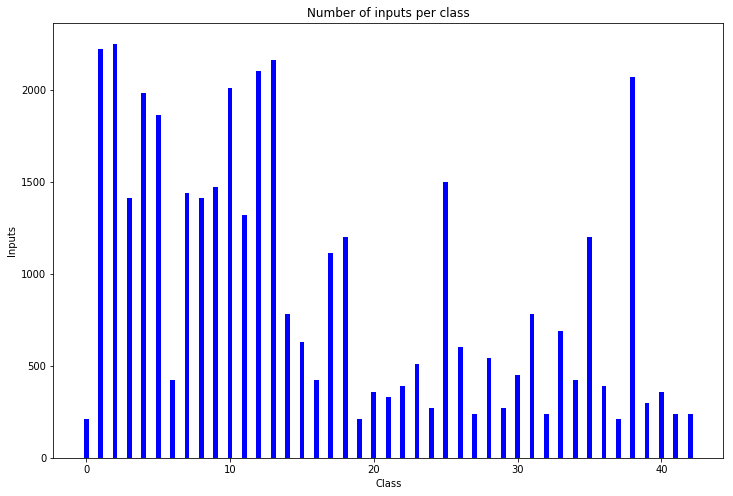

Testing Data


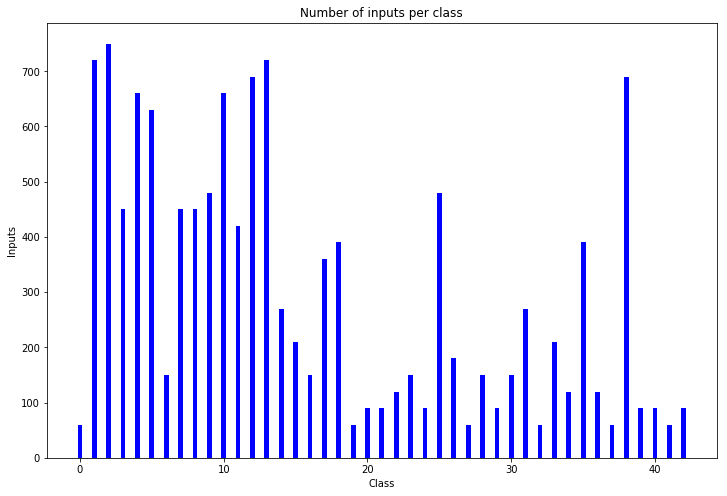

In [5]:
print('Training Data')
train_features = np.array(train['features'])
train_labels = np.array(train['labels'])

inputs_per_class = np.bincount(train_labels)
max_inputs = np.max(inputs_per_class)

mpl_fig = plt.figure(figsize=(12,8))
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()


print('Testing Data')
test_features = np.array(test['features'])
test_labels = np.array(test['labels'])

inputs_per_class = np.bincount(test_labels)
max_inputs = np.max(inputs_per_class)

mpl_fig = plt.figure(figsize=(12,8))
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()

In [6]:
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])
data_pd = pd.read_csv('signnames.csv')
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index=np.asarray(data_i_sorted).T[0])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0]).reset_index()
data_pd_sorted = data_pd_sorted.drop('index', 1)
data_pd_sorted

,ClassId,SignName,Occurance
0,2,Speed limit (50km/h),2250
1,1,Speed limit (30km/h),2220
2,13,Yield,2160
3,12,Priority road,2100
4,38,Keep right,2070
5,10,No passing for vehicles over 3.5 metric tons,2010
6,4,Speed limit (70km/h),1980
7,5,Speed limit (80km/h),1860
8,25,Road work,1500
9,9,No passing,1470


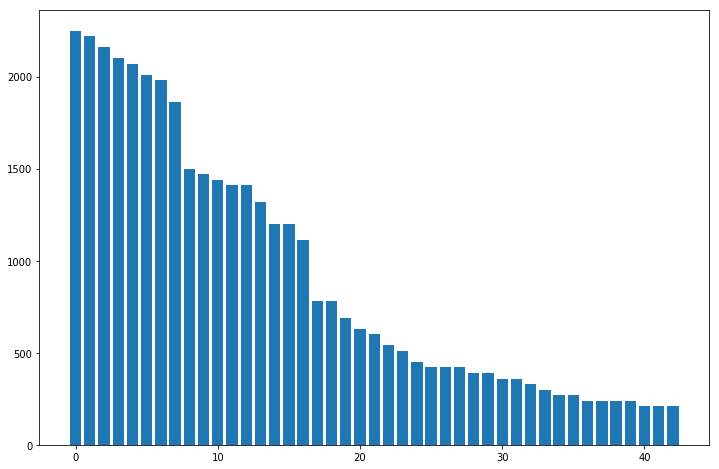

In [7]:
plt.figure(figsize=(12,8))
plt.bar(range(n_classes),height=data_pd_sorted["Occurance"])
plt.show()

List of Classes


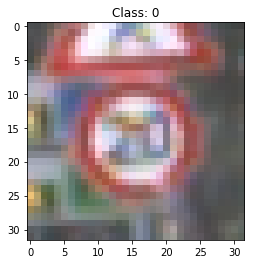

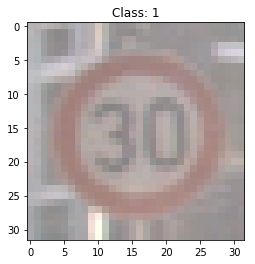

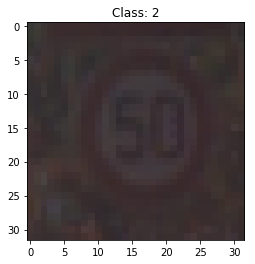

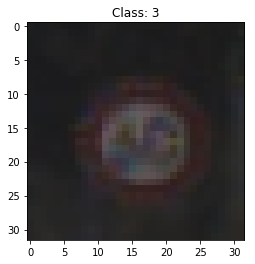

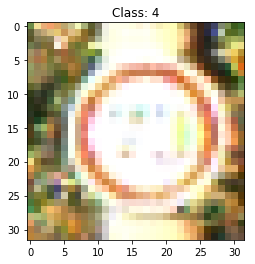

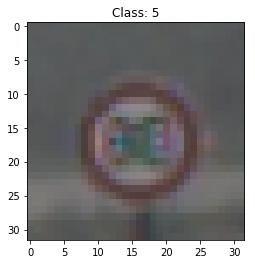

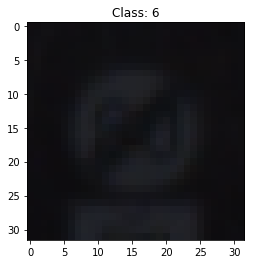

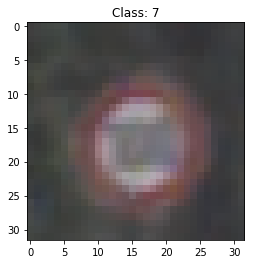

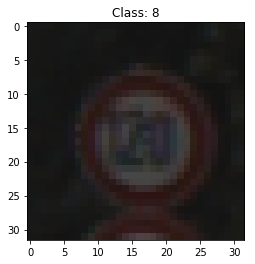

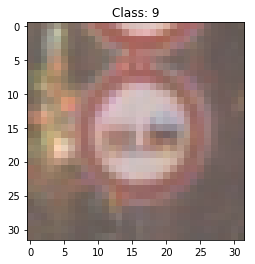

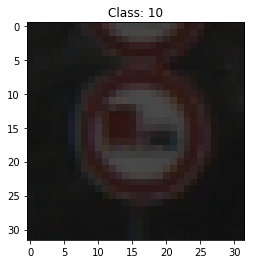

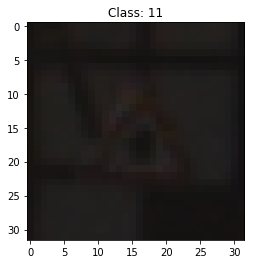

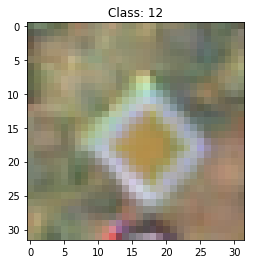

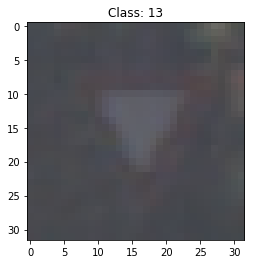

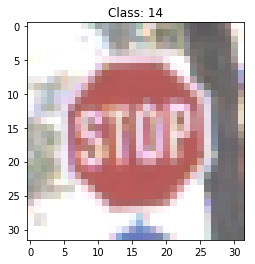

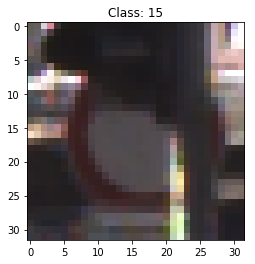

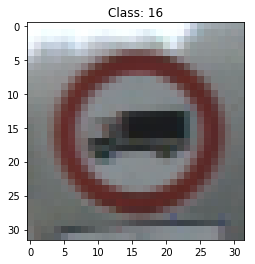

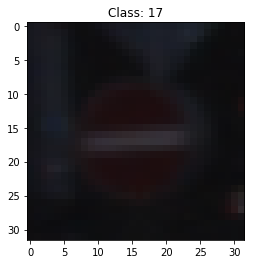

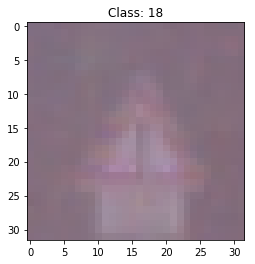

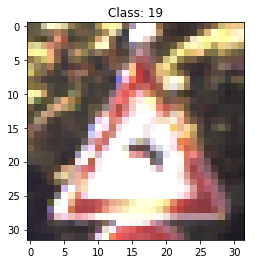

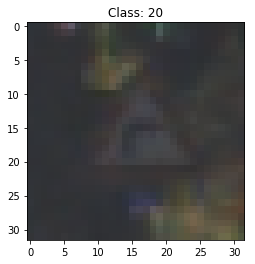

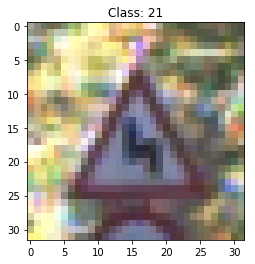

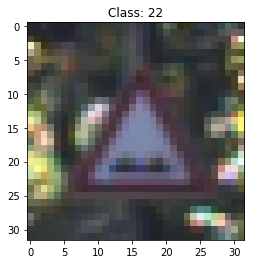

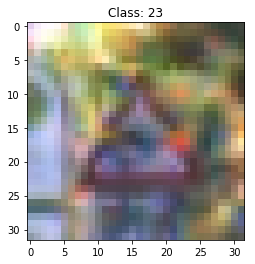

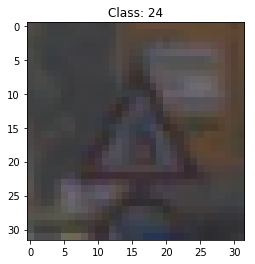

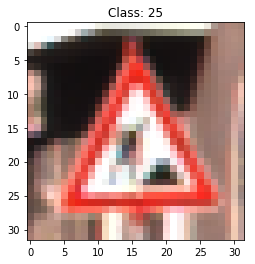

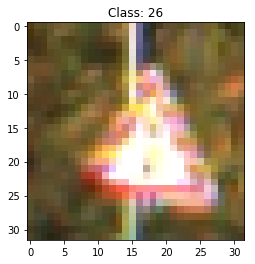

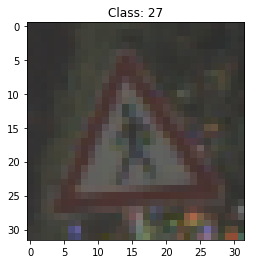

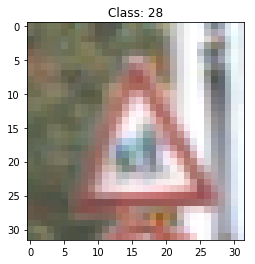

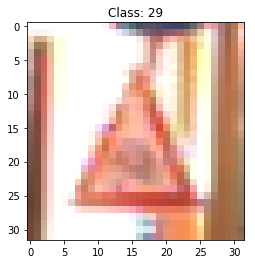

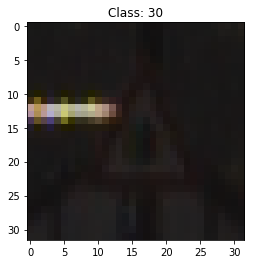

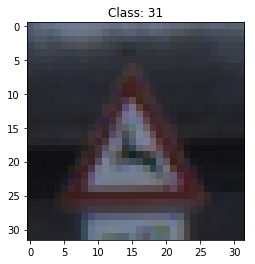

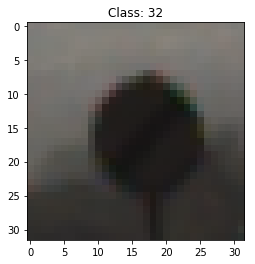

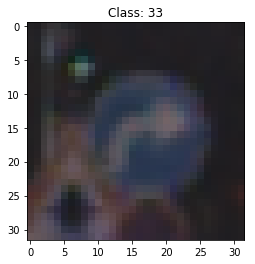

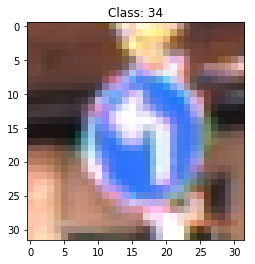

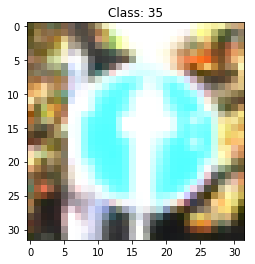

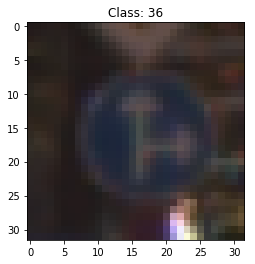

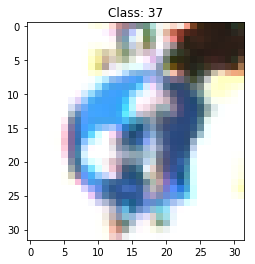

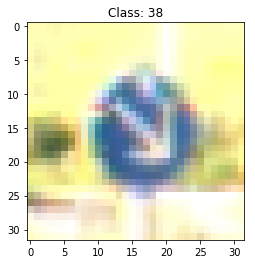

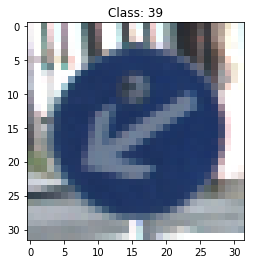

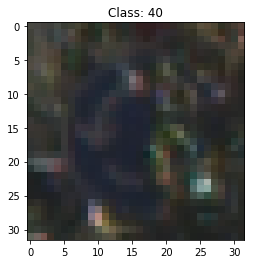

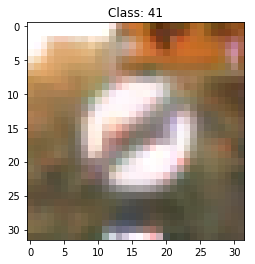

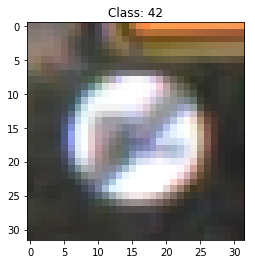

In [8]:
sign_dict = {}

print('List of Classes')
mpl_fig = plt.figure()
for i in range(n_classes):
    for j in range(len(train_labels)):
        if (i == train_labels[j]):
            sign_dict[i]=train_features[j]
            plt.title('Class: '+ str(i))
            plt.imshow(train_features[j])
            plt.show()
            break

# Add Extra Data to avoid OverFitting

In [9]:
def get_index_dict(y_train):
    # Returns indices of each label
    # Assumes that the labels are 0 to N-1
    dict_indices = {}
    ind_all = np.arange(len(y_train))

    for i in range(len(np.unique(y_train))):
        ind_i = ind_all[y_train == i]
        dict_indices[i] = ind_i
    return dict_indices

def transform_image(image,ang_range,shear_range,trans_range):

    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))    
   
    return image

def gen_extra_data(X_train,y_train,N_classes,n_each,ang_range,shear_range,trans_range,randomize_Var):    
    dict_indices = get_index_dict(y_train)
    n_class = len(np.unique(y_train)) 
    X_arr = []
    Y_arr = []
    n_train = len(X_train)
    for i in range(n_train):
        for i_n in range(n_each):
            img_trf = transform_image(X_train[i], ang_range,shear_range,trans_range)
            X_arr.append(img_trf)
            Y_arr.append(y_train[i])         
  
    return X_arr,Y_arr


i_train =1 
ang_rot = 10*0.9**(i_train)
trans_rot = 2*0.9**(i_train)
shear_rot = 2*0.9**(i_train)

#X_train,y_train = gen_extra_data(X_train,y_train,43,5,ang_rot,trans_rot,shear_rot,1)


#print('Training Data')
#train_features = np.array(X_train)
#train_labels = np.array(y_train)

#inputs_per_class = np.bincount(train_labels)
#max_inputs = np.max(inputs_per_class)

#mpl_fig = plt.figure(figsize=(12,8))
#ax = mpl_fig.add_subplot(111)
#ax.set_ylabel('Inputs')
#ax.set_xlabel('Class')
#ax.set_title('Number of inputs per class')
#ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
#plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# 2.1 Preprocessing


---Before and after Normalisation Sample---


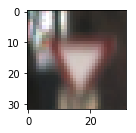

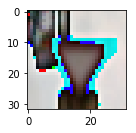

One hot encoding Validated

---Data shape---
Validation data shape (7842, 32, 32, 3)
Training data shape (31367, 32, 32, 3)
Testing data shape (12630, 32, 32, 3)

---Label shape---
Validation Label data shape (7842,)
Training Label data shape (31367,)
Testing Label data shape (12630,)


In [10]:
### Step 1
### Images are already resized the images to 32x32. so no padding required 



### Step 2
### its important to shuffle data because order of data could effect how well is network gets trained 
X_train, y_train = shuffle(X_train, y_train, random_state=42)



### Step 3 Normalisation (not standardising)
# The goal is to independently normalize each feature component to the [0,1] range
# In image processing, normalization is a process that changes the range of pixel intensity values.
# In stochastic gradient descent, Normalization can sometimes improve the convergence speed of the algorithm

X_train_org = X_train
X_test_org = X_test
X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))
print('')
print('---Before and after Normalisation Sample---')
image_index = 2 
plt.subplot(2,2,1)
plt.imshow(X_train_org[image_index])
plt.show()
plt.subplot(2,2,2)
plt.imshow(X_train[image_index])
plt.show()



### Step 4 Segmenting data into training, test, and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_validation_OneHot = OHE_Encode(y_validation,n_classes)
OHE_Validate(y_validation_OneHot,y_validation)



print('')
print('---Data shape---')
print('Validation data shape', X_validation.shape)
print('Training data shape', X_train.shape)
print('Testing data shape', X_test.shape)

print('')
print('---Label shape---')
print('Validation Label data shape', y_validation.shape)
print('Training Label data shape', y_train.shape)
print('Testing Label data shape', y_test.shape)

# Step 3: Define Network

# 3.1 Network parameters

In [11]:
n_filters = 32
kernel_size = (3, 3)
n_fc1 = 512
n_fc2 = 128
pool_size = 2 # i.e. (2,2)

dropout_conv = 0.9
dropout_fc = 0.9

weights_stddev = 0.1
weights_mean = 0.0
biases_mean = 0.0

padding = 'VALID'
if padding == 'SAME':
    conv_output_length = 6
elif padding == 'VALID':
    conv_output_length = 5
else:
    raiseException("Unknown padding.")

# 3.2 tf Graph input

In [12]:
x_unflattened = tf.placeholder("float", [None, image_shape[0],image_shape[1],image_shape[2]])
x = x_unflattened

y_rawlabels = tf.placeholder("int32", [None])
y = tf.one_hot(y_rawlabels, depth=n_classes, on_value=1., off_value=0., axis=-1)

# 3.3 Model

In [13]:
def weight_variable(shape, weight_mean, weight_stddev):
    return tf.Variable(tf.truncated_normal(shape, stddev=weight_stddev, mean=weight_mean))

def bias_variable(shape, bias_mean):
    return tf.Variable(tf.constant(bias_mean, shape=shape))

def conv2d(x, W, b, strides=3):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2, padding_setting='SAME'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding_setting)

def plot_metric_per_epoch(accuracies):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(accuracies):
        x_epochs.append(i)
        y_epochs.append(val)
        
    plt.figure(figsize=(15,8))
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    #plt.legend()
    plt.grid() 
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.show()

In [14]:
weights = {
    'conv1': weight_variable([kernel_size[0], kernel_size[1], n_channels, n_filters], weights_mean, weights_stddev),
    'fc1': weight_variable([n_filters * conv_output_length**2, n_fc1], weights_mean, weights_stddev),
    'fc2': weight_variable([n_fc1, n_fc2], weights_mean, weights_stddev),
    'out': weight_variable([n_fc2, n_classes], weights_mean, weights_stddev)
}

biases = {
    'conv1': bias_variable([n_filters], biases_mean),
    'fc1': bias_variable([n_fc1], biases_mean),
    'fc2': bias_variable([n_fc2], biases_mean),
    'out': bias_variable([n_classes], biases_mean)
}

In [15]:
def conv_net(model_x, model_weights, model_biases, model_pool_size, 
             model_dropout_conv, model_dropout_fc, padding='SAME'):
    
    # Convolution Layer 1
    conv1 = conv2d(model_x, model_weights['conv1'], model_biases['conv1'])
    
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=model_pool_size, padding_setting=padding)
    conv1 = tf.nn.dropout(conv1, model_dropout_conv)

    # Reshape conv1 output to fit fully connected layer input
    conv1_shape = conv1.get_shape().as_list()
    fc1 = tf.reshape(conv1, [-1, conv1_shape[1]*conv1_shape[2]*conv1_shape[3]])
    
    # Fully connected layer 1
    fc1 = tf.add(tf.matmul(fc1, model_weights['fc1']), model_biases['fc1'])
    fc1 = tf.nn.elu(fc1)
    fc1 = tf.nn.dropout(fc1, model_dropout_fc)
    
    # Fully connected layer 2
    fc2 = tf.add(tf.matmul(fc1, model_weights['fc2']), model_biases['fc2'])
    fc2 = tf.nn.elu(fc2)
    fc2 = tf.nn.dropout(fc2, model_dropout_fc)
    
    # Output layer
    output = tf.add(tf.matmul(fc2, model_weights['out']), model_biases['out'])

    return output

# Step 4: Train Model

# 4.1 Training Parameters

In [16]:
#learning Rate 
#It represents the step that is taken in a gradient decent algorithm to find an optimal solution.
#If steps is too big, algorithm can go from peak to peak, and skip lows altogether. 
#if steps is too small, algorithm will take lot of time to converge. 
#To train a model, it is often recommended to lower the learning rate as the training progresses. 
#We will use exponential_decay function to do so. 
#It requires 'initial learning rate' and 'global_step' value to compute the decayed learning rate. 
learning_rate = 0.001
initial_learning_rate = learning_rate
annealing_rate = 1

#epochs number
#this represents the number of times that we will run our main "for" loop. this is the loop that we will run to provide 
#data to our algorithms for training and testing.
#this is not number of batches
training_epochs = 150

#Batch Size 
#Deep learning algorithms are iterative in the sense that they load samples in batches to avoid running out of memory.
#number of batch (bin) = number of training samples / batch size. 
batch_size = 100

display_step = 1
anneal_mod_frequency = 15
print_accuracy_mod_frequency = 1

# 4.2 Model/Loss/Optimizer

In [17]:
# Construct model
pred = conv_net(x, weights, biases, pool_size, dropout_conv, dropout_fc, padding=padding)
pred_probs = tf.nn.softmax(pred)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 4.3 Train

Epoch: 0001 cost: 0.835354030 Time since last epoch:  5.350874185562134
epoch Accuracy (validation) = 0.719077, five_epoch_moving_average = 0.719077
Epoch: 0002 cost: 0.600972295 Time since last epoch:  5.97432804107666
epoch Accuracy (validation) = 0.799413, five_epoch_moving_average = 0.759245
Epoch: 0003 cost: 0.408585429 Time since last epoch:  5.97832989692688
epoch Accuracy (validation) = 0.838307, five_epoch_moving_average = 0.785599
Epoch: 0004 cost: 0.394816637 Time since last epoch:  5.910281181335449
epoch Accuracy (validation) = 0.849911, five_epoch_moving_average = 0.801677
Epoch: 0005 cost: 0.222693145 Time since last epoch:  5.989338397979736
epoch Accuracy (validation) = 0.865085, five_epoch_moving_average = 0.814359
Epoch: 0006 cost: 0.241149440 Time since last epoch:  5.948308706283569
epoch Accuracy (validation) = 0.868783, five_epoch_moving_average = 0.844300
Epoch: 0007 cost: 0.158790365 Time since last epoch:  5.961318254470825
epoch Accuracy (validation) = 0.8851

epoch Accuracy (validation) = 0.954731, five_epoch_moving_average = 0.950013
Epoch: 0056 cost: 0.007220398 Time since last epoch:  6.268500328063965
epoch Accuracy (validation) = 0.953073, five_epoch_moving_average = 0.950829
Epoch: 0057 cost: 0.072295405 Time since last epoch:  6.269501209259033
epoch Accuracy (validation) = 0.949885, five_epoch_moving_average = 0.950956
Epoch: 0058 cost: 0.004718235 Time since last epoch:  6.334547996520996
epoch Accuracy (validation) = 0.94963, five_epoch_moving_average = 0.951313
Epoch: 0059 cost: 0.110409088 Time since last epoch:  6.3015241622924805
epoch Accuracy (validation) = 0.954221, five_epoch_moving_average = 0.952308
Epoch: 0060 cost: 0.083273195 Time since last epoch:  6.325541257858276
New learning rate:  0.001
epoch Accuracy (validation) = 0.948865, five_epoch_moving_average = 0.951135
Epoch: 0061 cost: 0.020478291 Time since last epoch:  6.246484756469727
epoch Accuracy (validation) = 0.952181, five_epoch_moving_average = 0.950956
Epo

Epoch: 0110 cost: 0.002060802 Time since last epoch:  6.6337316036224365
epoch Accuracy (validation) = 0.957281, five_epoch_moving_average = 0.957689
Epoch: 0111 cost: 0.108816624 Time since last epoch:  6.636765241622925
epoch Accuracy (validation) = 0.956771, five_epoch_moving_average = 0.957383
Epoch: 0112 cost: 0.026132941 Time since last epoch:  6.74183988571167
epoch Accuracy (validation) = 0.959959, five_epoch_moving_average = 0.957536
Epoch: 0113 cost: 0.093736030 Time since last epoch:  6.73883843421936
epoch Accuracy (validation) = 0.958684, five_epoch_moving_average = 0.957740
Epoch: 0114 cost: 0.001585683 Time since last epoch:  6.722826719284058
epoch Accuracy (validation) = 0.958684, five_epoch_moving_average = 0.958276
Epoch: 0115 cost: 0.002818441 Time since last epoch:  6.809889078140259
epoch Accuracy (validation) = 0.961107, five_epoch_moving_average = 0.959041
Epoch: 0116 cost: 0.061915379 Time since last epoch:  6.718854188919067
epoch Accuracy (validation) = 0.961

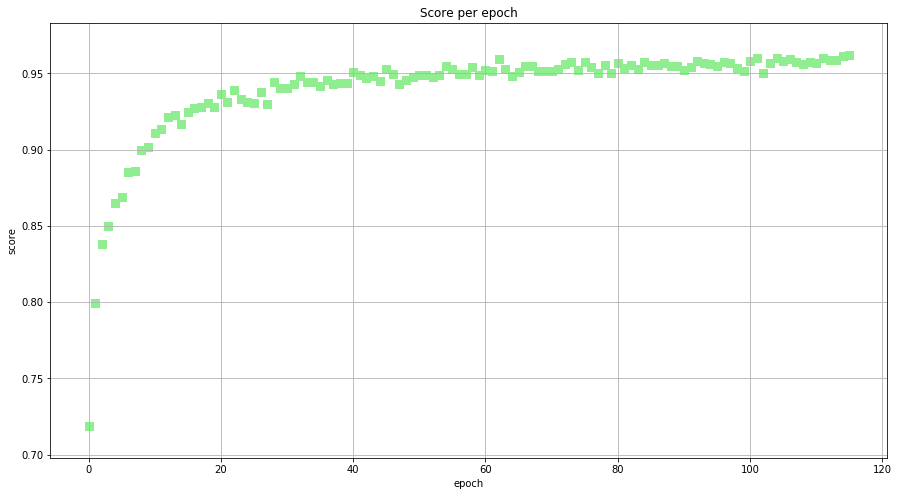

In [18]:
# Function to initialise the variables
init = tf.global_variables_initializer()

# Launch the graph
sess = tf.Session()

# Initialise variables
sess.run(init)

# Initialise time logs
init_time = time.time()
epoch_time = init_time

five_epoch_moving_average = 0.
epoch_accuracies = []
print_accuracy_mod_frequency = 1
total_batch = int(len(X_train) / batch_size)

# Training cycle
for epoch in range(training_epochs):
    if five_epoch_moving_average > 0.96:
        break        

    for i in range(total_batch):
        batch_x, batch_y = np.array(X_train[i * batch_size:(i + 1) * batch_size]), \
                           np.array(y_train[i * batch_size:(i + 1) * batch_size])
        _, epoch_cost = sess.run([optimizer, cost], feed_dict={x_unflattened: batch_x, y_rawlabels: batch_y})
              
    # Display logs per epoch step
    if epoch % display_step == 0:
        last_epoch_time = epoch_time
        epoch_time = time.time()
        print("Epoch:", '%04d' % (epoch + 1), "cost:","{:.9f}".format(epoch_cost), "Time since last epoch: ", epoch_time - last_epoch_time)
        
    # Anneal learning rate
    if (epoch + 1) % anneal_mod_frequency == 0:
        learning_rate *= annealing_rate
        print("New learning rate: ", learning_rate)

    if (epoch + 1) % print_accuracy_mod_frequency == 0:
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        # Line below needed only when not using `with tf.Session() as sess`
        with sess.as_default():
            epoch_accuracy = accuracy.eval({x_unflattened: X_validation, y_rawlabels: y_validation})           
            epoch_accuracies.append(epoch_accuracy)
            
            ji = (len(epoch_accuracies), 5)[len(epoch_accuracies)>4]
            five_epoch_moving_average = np.sum(epoch_accuracies[epoch+1-ji:epoch+1])/ji
            print("epoch Accuracy (validation) = " + str(epoch_accuracy) + ", five_epoch_moving_average = " + "{:.6f}".format(five_epoch_moving_average))
              

print("Optimization Finished!")
plot_metric_per_epoch(epoch_accuracies)

# 4.4 Test Model

In [19]:
# Test model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

with sess.as_default():
    print("Accuracy (test):", accuracy.eval({x_unflattened: X_test, y_rawlabels: y_test}))
    
# Print parameters for reference
print("\nParameters:")
print("Learning rate (initial): ", initial_learning_rate)
print("Anneal learning rate every ", anneal_mod_frequency, " epochs by ", 1 - annealing_rate)
print("Learning rate (final): ", learning_rate)
print("Training epochs: ", training_epochs)
print("Batch size: ", batch_size)
print("Dropout (conv): ", dropout_conv)
print("Dropout (fc): ", dropout_fc)
print("Padding: ", padding)
print("weights_mean: ", weights_mean)
print("weights_stddev: ", weights_stddev)
print("biases_mean: ", biases_mean)

Accuracy (test): 0.793508

Parameters:
Learning rate (initial):  0.001
Anneal learning rate every  15  epochs by  0
Learning rate (final):  0.001
Training epochs:  150
Batch size:  100
Dropout (conv):  0.9
Dropout (fc):  0.9
Padding:  VALID
weights_mean:  0.0
weights_stddev:  0.1
biases_mean:  0.0


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

See Section 2.1 for Preprocessing steps 

1. As image was 32x32 no Padding done  
2. avoid overfitting by features randomization
3. data normallized to avoid high variance and improve classifier performance 
4. labels one hot encoded 
5. Added Extra data for low frequency Sign classes 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

See Section 2.1 for Splitting Data 

1. Training and test data were already separated (downloaded pickled files train.p and test.p).
2. shuffled the training data because they were arranged in ascending order by label. If I don't shuffle the training data, the first series of batches will all be the first type of sign followed by the second type and so on. This will distort the learning process.  
3. I further split the training data into test and valdiation sets so the model wouldn't be cheating when we optimised it.  
4. Improvement: Generate additional data. The number of examples in the training data for each class is uneven, so the model may be biased towards predicting an unknown sign belongs to a class where there is abundant training data since we are minimising the training loss.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

See 3.3 for Model / Network Defination

* 3-layer Convolutional Neural Network.
* It consists of one convolution layer (feature extraction) followed by two fully connected layers (ReLU activation) 
  and a single fully connected linear classifier.
  
  1 : Convolution layer 
  Input: (32, 32, 3)  
  Output: (5, 5, 32)
  'VALID' padding
  Filters: 32
  Stride: 3
  ReLU Activation
  2D Max Pooling (down-sampling) layer
  Dropout: 0.9 
  
  2 : Reshape Layer
  Input: (5, 5, 32)
  Output: 800
  
  3 : Fully connected layer  
  Input: 800
  Output: 512
  ReLU Activation
  Dropout: 0.9
  
  4 : Fully connected layer  
  Input: 512
  Output: 128
  ReLU Activation
  Dropout: 0.9
  
  5 : output layer  
  Input: 128
  Output: 43

* The network uses full colour information (all three channels) and normalised data.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


See Section 4.3 

* Type of optimiser: AdamOptimizer
* Batch size: 100
* Training Epochs: 105(with ELU) 
* Learning rate: 0.001

Network Parameters:
* Dropout (conv layer): 0.9
* Dropout (fully connected layers): 0.9
* Padding: VALID

tf.train.AdamOptimizer 
ref 
http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow

•Main advantage of Adam over the simple tf.train.GradientDescentOptimizer:  Uses moving averages of the parameters 
(momentum) -> enables Adam to use a larger effective step size, and the algorithm will converge to this 
step size without fine tuning. A simple tf.train.GradientDescentOptimizer would require more hyperparameter tuning before it 
would converge as quickly.


•Disadvantage: 
Adam requires more computation to be performed for each parameter in each training step 
(to maintain the moving averages and variance, and calculate the scaled gradient) and
more state to be retained for each parameter 
(approximately tripling the size of the model to store the average and variance for each parameter). 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**


**1. First attempt: building a minimum viable model and debugging**
- I wanted to get a working model first. I started with a basic multilayer perceptron which I adapted from `TensorFlow-Examples`. I trained it for 15 epochs, which had an accuracy of 6% on the training and test sets. I then trained a two-layer convolutional neural network for 15 epochs which had an accuracy of 5-6% on the training and test sets. 
    - The accuracy was lower than I expected and the cost seemed high (of order 10^6 in the first epoch, 10^5 in the second and third and in the hundreds in the tenth epoch), so I adjusted parameters hoping to improve it before training for longer.
    - The cost reduced significantly (to single digits by the second epoch as opposed to order 10^5) after I added a small positive bias to the initial weights and biases. Strangely, the accuracy did not increase, but remained at 5-6%. The cost did not decrease significantly over the next 10 epochs either.
    - I went on Slack to see what results people were getting to get a feel for how wrong I was. I saw that people often trained their networks for hundreds of epochs so I thought it would be good to train my network for e.g. 100 epochs.
- I rewrote the multilayer perceptron in a Python Script and it worked fine, returning an accuracy of over 70% accuracy within 2 epochs.

**2. Improvements to the model**
- I then added a convolution layer before the two fully connected layers and the output layer.
- This new model produced a validation accuracy of above 90% after 15 epochs (parameters not tuned), which was higher than that for the two-layer feedforward network. So I chose this model with a convolution layer.

** 3. Tuning Parameters**
- I altered the model code (replaced hard-coded numbers with variables) so I could tweak parameters easily.
- I tested models with different values or settings for
    * dropout for the fully connected layers,
    * dropout for the convolution layer,
    * padding (SAME vs VALID),
    * weight and bias initialisation
    * maxpool vs no max pool
- I used Keras to implement comparisons so I could get full figures on training and validation loss and accuracy easily.
- I stopped when the model reached a validation accuracy of over 95% within 100 epochs. 
    * This figure is strange because my models implemented in Keras reach validation accuracy of over 99% within 15 epochs.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [20]:
def read_image_and_print_dims(image_path):
    image = mpimg.imread(image_path)
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  
    return image

def process_image_file(name):
    image = cv2.imread(name)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.-.5
    return image

def plot_image_grid(n_row,n_col,X):
    plt.figure(figsize = (8,6))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = i
        plt.imshow(X[ind_plot])
        plt.axis('off')
    plt.show()    

def predict(img):
    classification = sess.run(tf.argmax(pred, 1), feed_dict={x_unflattened: [img]})
    print('NN predicted', classification[0])    
    plt.imshow(sign_dict[classification[0]])    
    plt.show()
    
def top_5_predictions(img):
    #Return model's top five choices for what traffic sign this image is and its confidence in its predictions.
    top_five_certainties = sess.run(tf.nn.top_k(tf.nn.softmax(pred), k=5), feed_dict={x_unflattened: [img]})
    print("Top five: ", top_five_certainties)
    plot_certainty_arrays(top_five_certainties[0][0], top_five_certainties[1][0])
    return top_five_certainties
    
def plot_certainty_arrays(probabilities, labels):
    # Plot model's probabilities (y) and traffic sign labels (x) in a bar chart.
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, probabilities, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel('Probability')
    plt.xlabel('Traffic sign')
    plt.title('Model\'s certainty of its predictions')
    plt.show()
    print("Traffic Sign Key")
    for label in labels:
        print(label, ": ", data_pd.loc[label]['SignName'])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

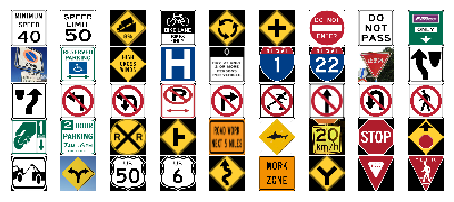

In [21]:
newdata = [process_image_file("./new_signs/"+name) for name in os.listdir("./new_signs/")]
namenewdata = [name for name in os.listdir("./new_signs/")]
newdata = np.array(newdata ,dtype = np.float32)
plot_image_grid(9,5,newdata+.5)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**






40mph.png


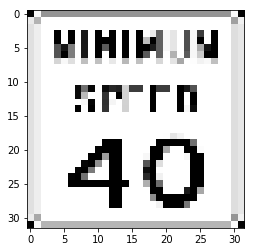

NN predicted 25


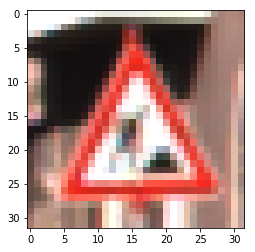






50mph.png


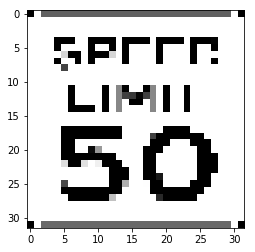

NN predicted 25


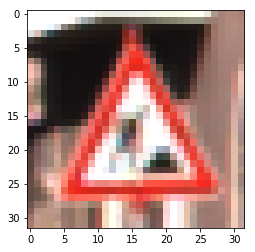






8pcGrade.png


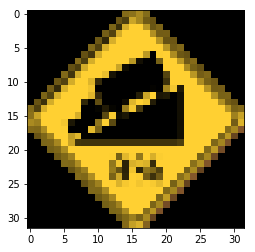

NN predicted 5


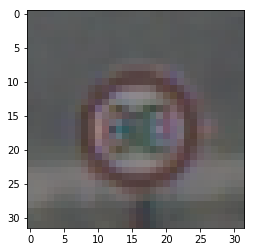






bikelane.png


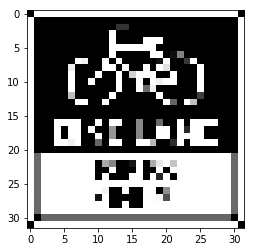

NN predicted 25


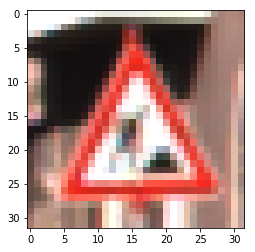






circle.png


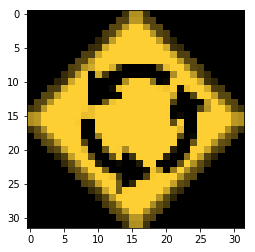

NN predicted 12


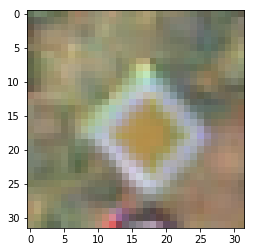






CrossRoad.png


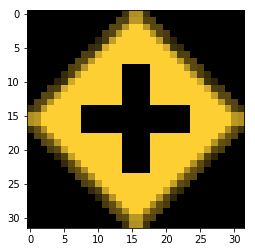

NN predicted 20


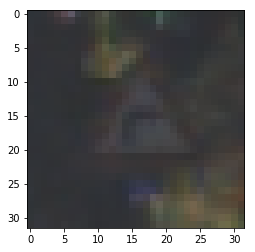






DonotEnter.png


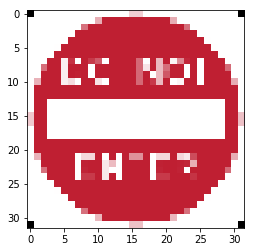

NN predicted 17


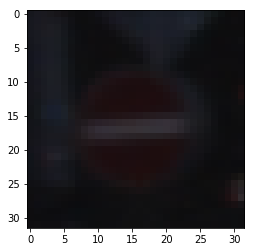






DoNotPass.png


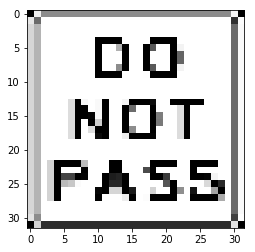

NN predicted 20


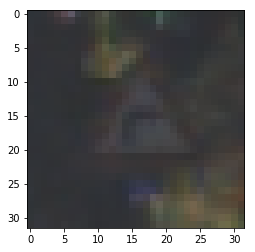






EZPass.png


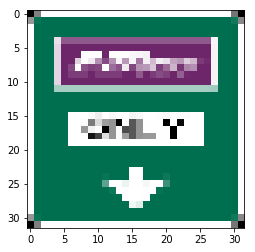

NN predicted 13


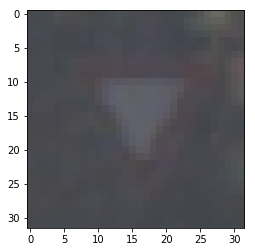






german_sign.png


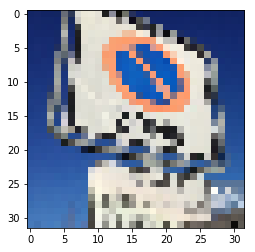

NN predicted 30


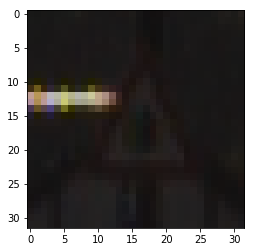






HCparking.png


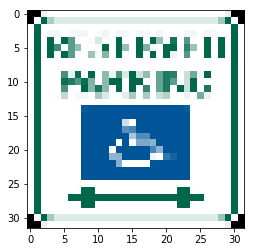

NN predicted 33


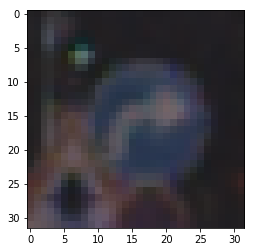






HighXWinds.png


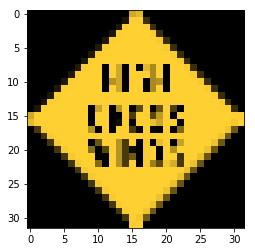

NN predicted 26


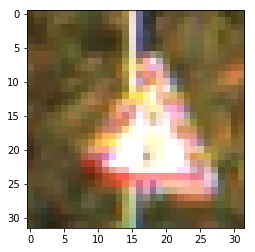






Hospital.png


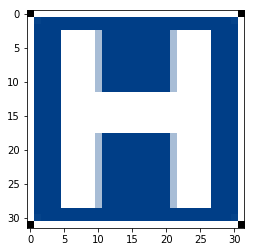

NN predicted 12


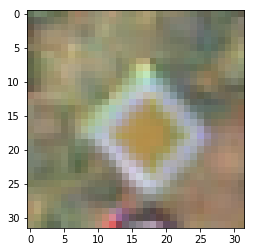






HOW.png


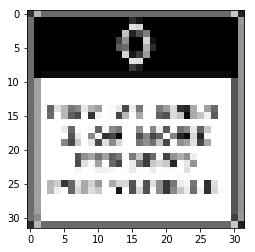

NN predicted 33


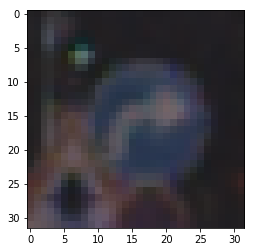






i1.png


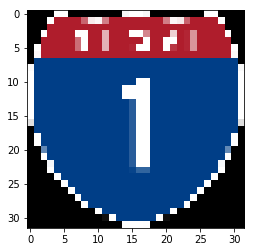

NN predicted 35


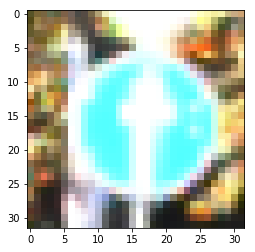






i22.png


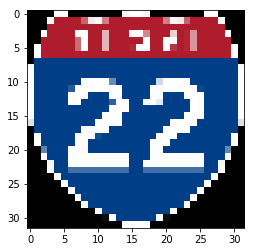

NN predicted 38


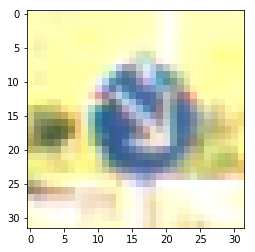






japanese_sign_resized.png


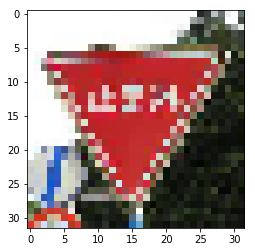

NN predicted 14


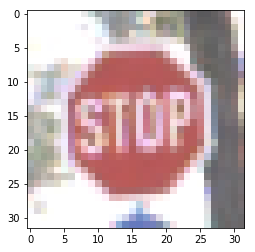






keepleft.png


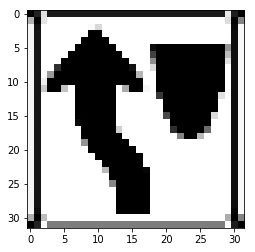

NN predicted 13


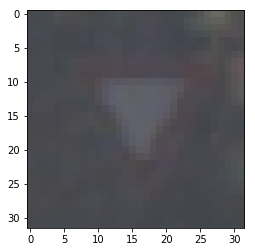






keepright.png


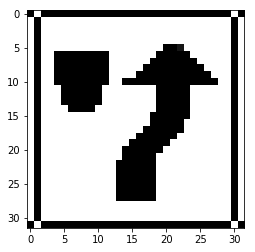

NN predicted 13


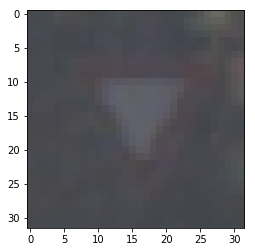






noleft.png


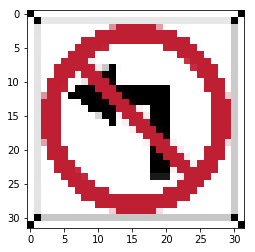

NN predicted 2


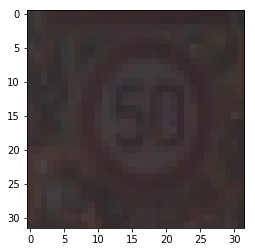






noleftUturn.png


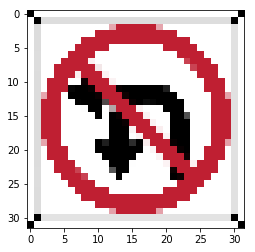

NN predicted 9


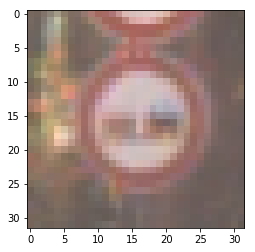






NoParking.png


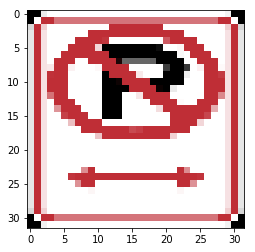

NN predicted 33


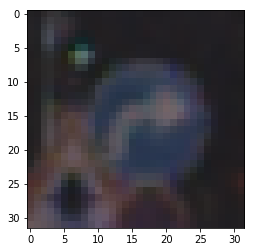






noright.png


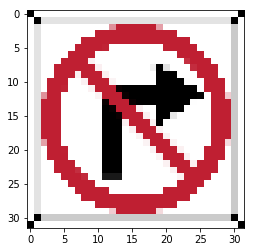

NN predicted 33


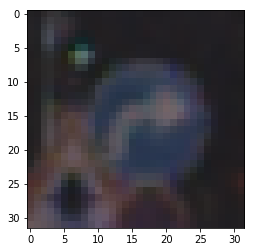






noRoller.png


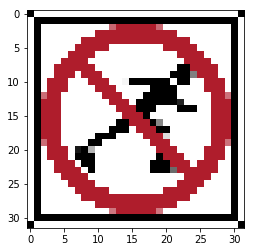

NN predicted 9


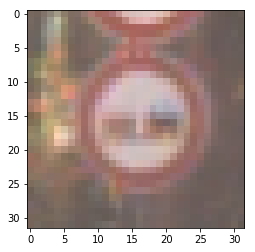






nostraight.png


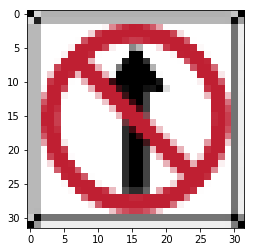

NN predicted 1


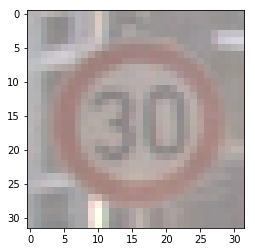






noUturn.png


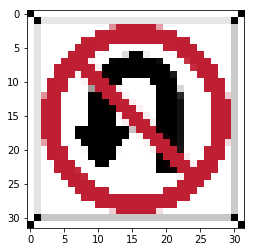

NN predicted 35


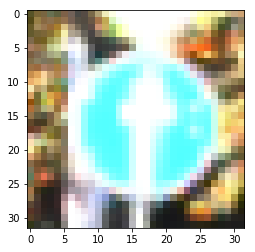






noWalking.png


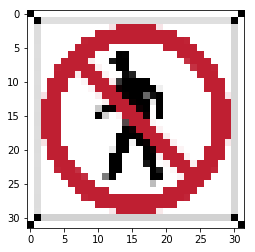

NN predicted 1


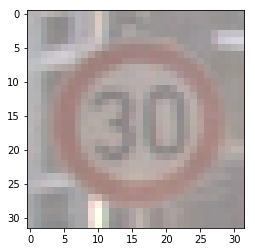






paidParking.png


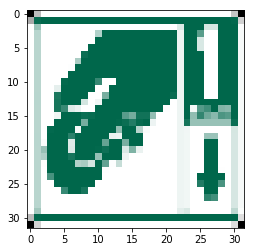

NN predicted 33


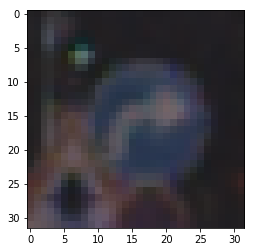






parking2hr.png


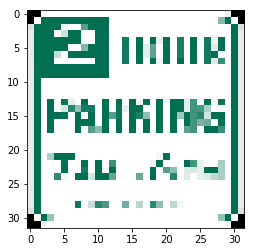

NN predicted 25


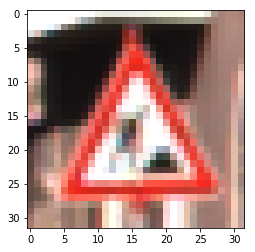






RailRoad.png


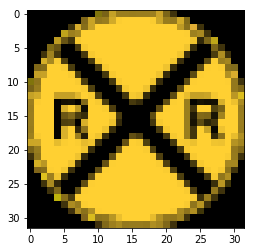

NN predicted 12


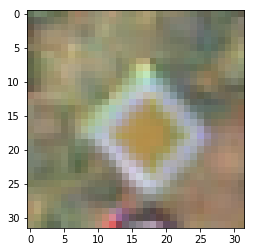






RightCrossing.png


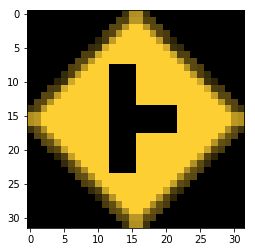

NN predicted 20


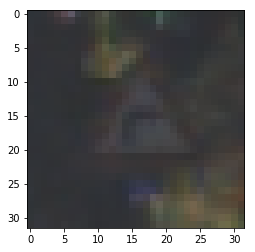






roadwork.png


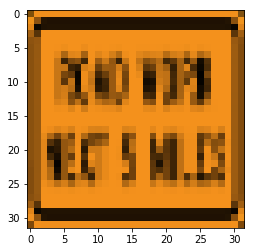

NN predicted 12


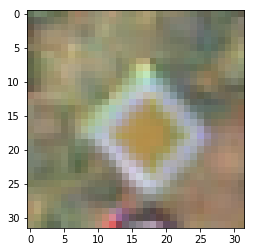






shark_sign.png


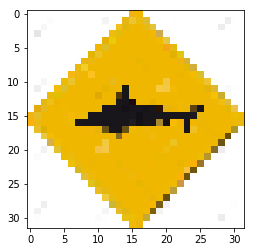

NN predicted 12


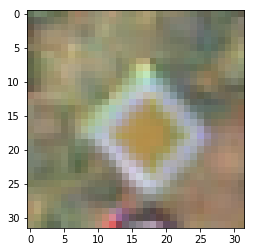






speed_limit_stop.png


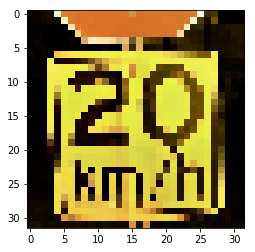

NN predicted 12


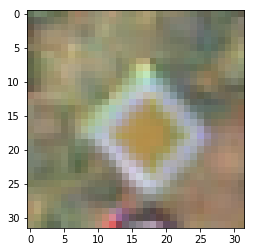






stop.png


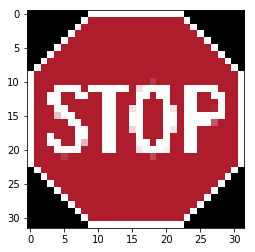

NN predicted 1


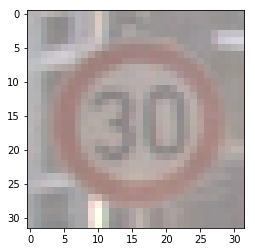






StopAhead.png


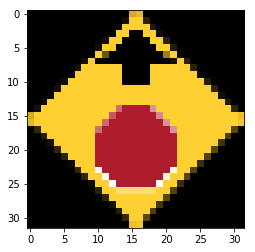

NN predicted 12


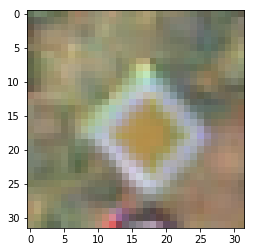






TowAway.png


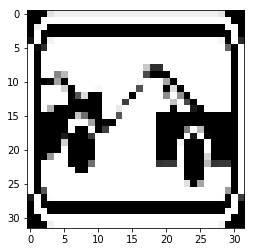

NN predicted 22


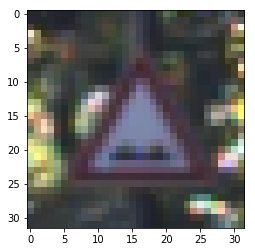






two_way_sign.png


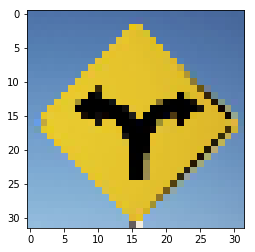

NN predicted 0


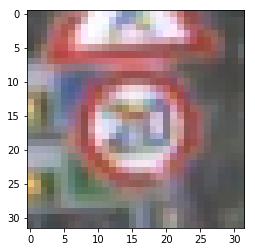






US50.png


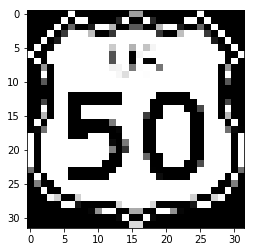

NN predicted 21


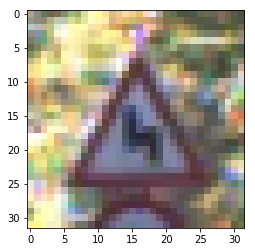






US6.png


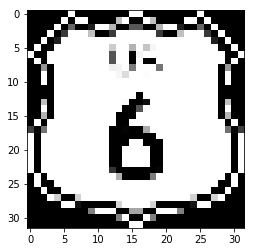

NN predicted 11


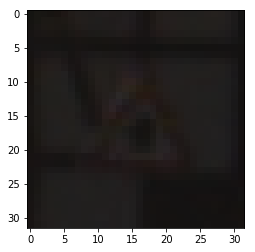






windyRight.png


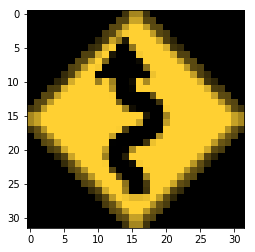

NN predicted 12


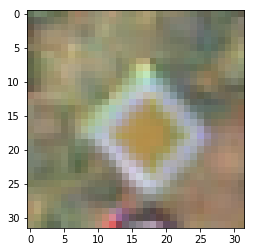






workzone.png


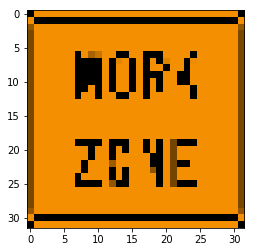

NN predicted 12


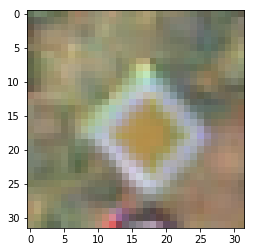






YCrossing.png


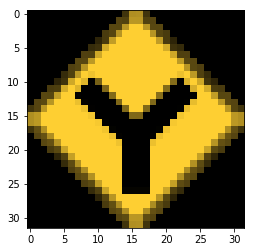

NN predicted 12


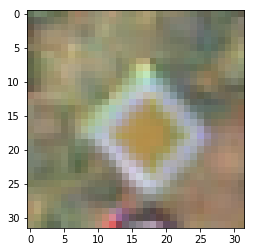






yeild.png


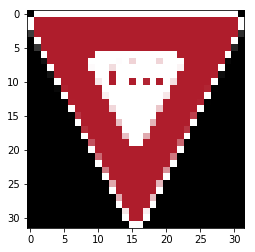

NN predicted 13


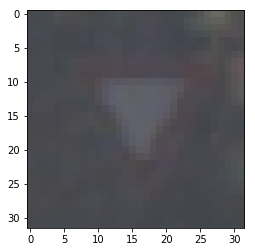






yield_pedestrian.png


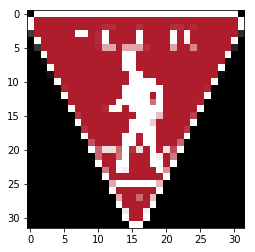

NN predicted 12


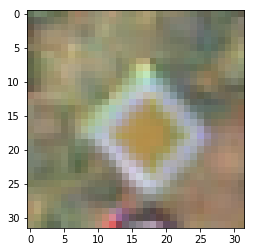

In [22]:
for i in range(len(namenewdata)):
    print('\n\n\n\n')
    print(namenewdata[i])
    plt.imshow(newdata[i]+.5)
    plt.show()
    predict(newdata[i]) 

No, it does not perform equally well on captured images. It has a performance of 0% accuracy on captured images as opposed to 79% on the test set.
•The images not included in the dataset are not exactly the same road signs so there is additional difficulty because the model needs to generalise well to classify these new signs correctly. The
•Some road signs such as the shark sign may not even be included in the 43 categories.
•The images are also processed (e.g. cropped) differently.

It seems that the model is classifying 'unknown signs' as Roundabout Mandatory signs.


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

•The model is certain of all of its predictions even though some are wrong. 
•The model also predicts different outcomes confidently for the two times I ran the predictions on each sign. 

These are both strange outcomes.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.






40mph.png


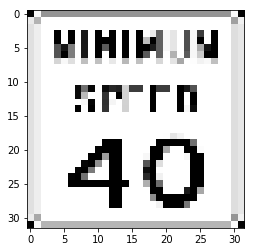

Top five:  TopKV2(values=array([[  9.99965072e-01,   3.48573485e-05,   9.53655004e-08,
          5.30022311e-11,   4.23061922e-14]], dtype=float32), indices=array([[25, 28, 13, 14, 12]]))


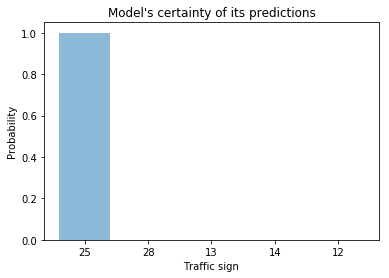

Traffic Sign Key
25 :  Road work
28 :  Children crossing
13 :  Yield
14 :  Stop
12 :  Priority road





50mph.png


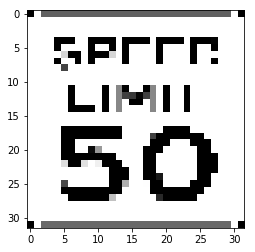

Top five:  TopKV2(values=array([[  1.00000000e+00,   1.46745028e-29,   1.35838156e-29,
          1.21232870e-30,   4.28406213e-32]], dtype=float32), indices=array([[25, 33, 13, 40, 19]]))


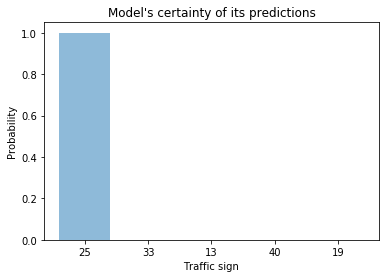

Traffic Sign Key
25 :  Road work
33 :  Turn right ahead
13 :  Yield
40 :  Roundabout mandatory
19 :  Dangerous curve to the left





8pcGrade.png


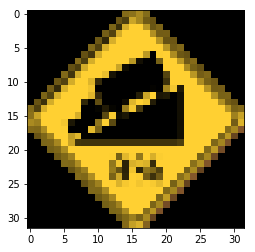

Top five:  TopKV2(values=array([[  9.34373081e-01,   6.01442643e-02,   5.23917377e-03,
          2.43519113e-04,   1.50220853e-14]], dtype=float32), indices=array([[12, 20,  5,  3, 42]]))


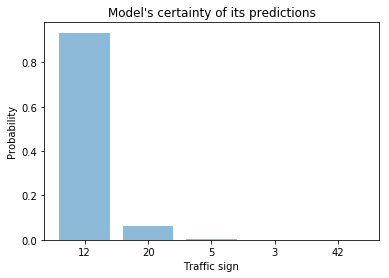

Traffic Sign Key
12 :  Priority road
20 :  Dangerous curve to the right
5 :  Speed limit (80km/h)
3 :  Speed limit (60km/h)
42 :  End of no passing by vehicles over 3.5 metric tons





bikelane.png


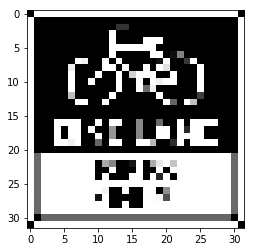

Top five:  TopKV2(values=array([[  9.99993324e-01,   6.67676613e-06,   1.72000980e-09,
          2.67864536e-10,   1.98939309e-10]], dtype=float32), indices=array([[12, 26, 28, 25, 20]]))


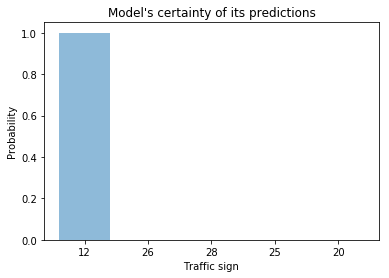

Traffic Sign Key
12 :  Priority road
26 :  Traffic signals
28 :  Children crossing
25 :  Road work
20 :  Dangerous curve to the right





circle.png


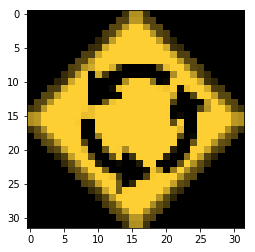

Top five:  TopKV2(values=array([[  1.00000000e+00,   1.11131870e-33,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[12,  8,  0,  1,  2]]))


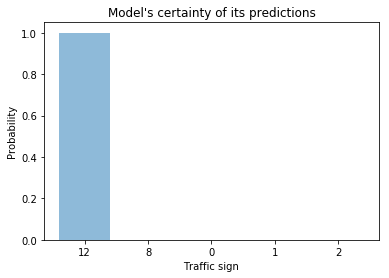

Traffic Sign Key
12 :  Priority road
8 :  Speed limit (120km/h)
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)
2 :  Speed limit (50km/h)





CrossRoad.png


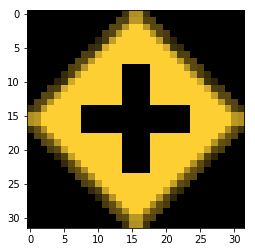

Top five:  TopKV2(values=array([[  1.00000000e+00,   6.52831078e-15,   6.28363006e-15,
          7.22331169e-16,   5.61500953e-18]], dtype=float32), indices=array([[12, 25, 20, 30, 31]]))


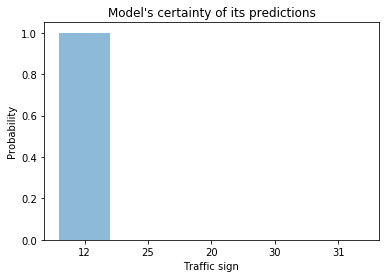

Traffic Sign Key
12 :  Priority road
25 :  Road work
20 :  Dangerous curve to the right
30 :  Beware of ice/snow
31 :  Wild animals crossing





DonotEnter.png


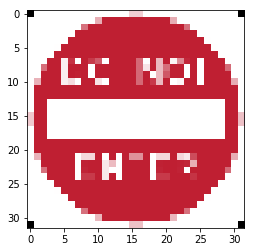

Top five:  TopKV2(values=array([[  9.99999523e-01,   4.68118913e-07,   7.32648371e-13,
          1.17335677e-17,   8.93368379e-18]], dtype=float32), indices=array([[17, 25,  1, 14,  2]]))


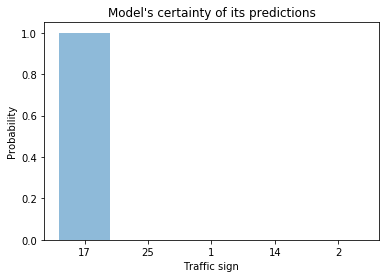

Traffic Sign Key
17 :  No entry
25 :  Road work
1 :  Speed limit (30km/h)
14 :  Stop
2 :  Speed limit (50km/h)





DoNotPass.png


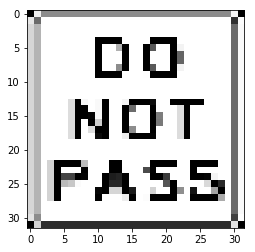

Top five:  TopKV2(values=array([[  9.99998689e-01,   8.35011463e-07,   4.23040120e-07,
          5.35495148e-10,   7.56928201e-11]], dtype=float32), indices=array([[20,  3, 10, 21, 31]]))


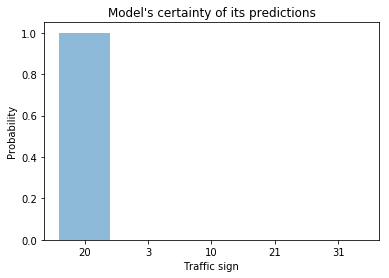

Traffic Sign Key
20 :  Dangerous curve to the right
3 :  Speed limit (60km/h)
10 :  No passing for vehicles over 3.5 metric tons
21 :  Double curve
31 :  Wild animals crossing





EZPass.png


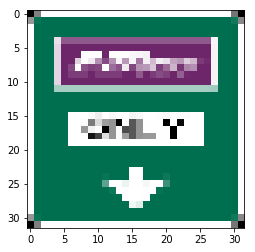

Top five:  TopKV2(values=array([[  1.00000000e+00,   3.34847494e-20,   3.01740457e-22,
          2.34127782e-22,   5.46599749e-24]], dtype=float32), indices=array([[13,  5, 12, 38, 25]]))


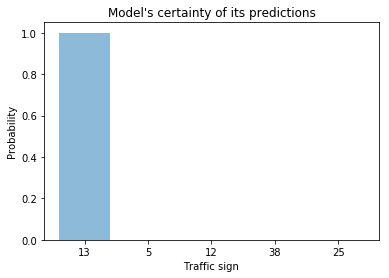

Traffic Sign Key
13 :  Yield
5 :  Speed limit (80km/h)
12 :  Priority road
38 :  Keep right
25 :  Road work





german_sign.png


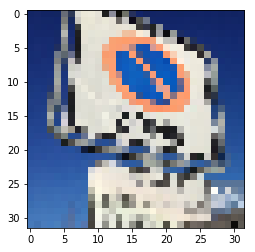

Top five:  TopKV2(values=array([[  9.59407389e-01,   3.94117013e-02,   1.05212280e-03,
          9.47257286e-05,   1.95071989e-05]], dtype=float32), indices=array([[28, 30, 39, 41, 16]]))


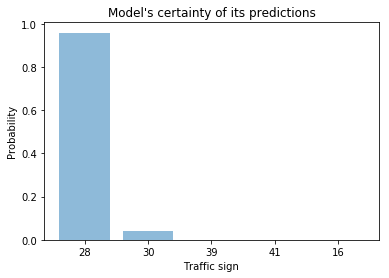

Traffic Sign Key
28 :  Children crossing
30 :  Beware of ice/snow
39 :  Keep left
41 :  End of no passing
16 :  Vehicles over 3.5 metric tons prohibited





HCparking.png


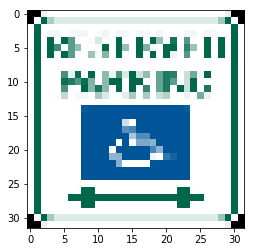

Top five:  TopKV2(values=array([[  1.00000000e+00,   1.62666736e-09,   1.30975786e-11,
          1.23612373e-12,   6.92642399e-17]], dtype=float32), indices=array([[33, 35, 20, 40, 23]]))


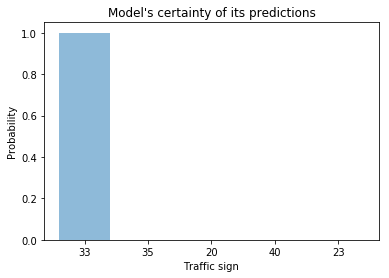

Traffic Sign Key
33 :  Turn right ahead
35 :  Ahead only
20 :  Dangerous curve to the right
40 :  Roundabout mandatory
23 :  Slippery road





HighXWinds.png


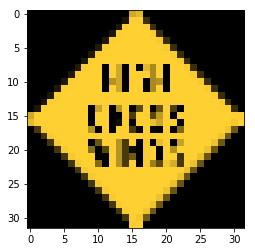

Top five:  TopKV2(values=array([[  9.97674763e-01,   1.59696769e-03,   7.22067547e-04,
          6.17395062e-06,   3.94209491e-12]], dtype=float32), indices=array([[12, 26, 25,  5, 22]]))


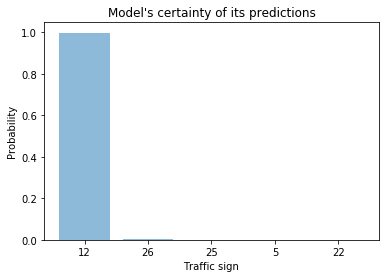

Traffic Sign Key
12 :  Priority road
26 :  Traffic signals
25 :  Road work
5 :  Speed limit (80km/h)
22 :  Bumpy road





Hospital.png


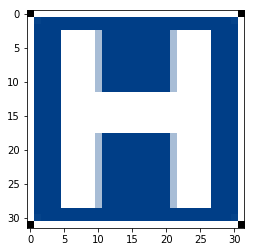

Top five:  TopKV2(values=array([[  1.00000000e+00,   3.00917657e-13,   7.56618109e-24,
          1.29688733e-24,   1.29791112e-25]], dtype=float32), indices=array([[12, 17, 23,  5,  9]]))


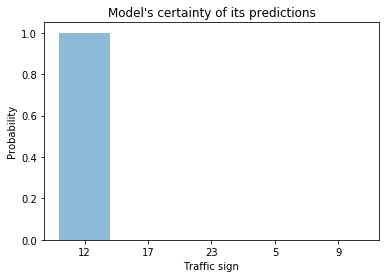

Traffic Sign Key
12 :  Priority road
17 :  No entry
23 :  Slippery road
5 :  Speed limit (80km/h)
9 :  No passing





HOW.png


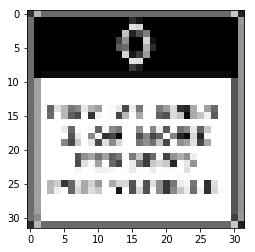

Top five:  TopKV2(values=array([[  7.71307647e-01,   2.28692353e-01,   6.40906439e-09,
          3.23991187e-13,   1.66075717e-14]], dtype=float32), indices=array([[33, 25, 22, 13, 12]]))


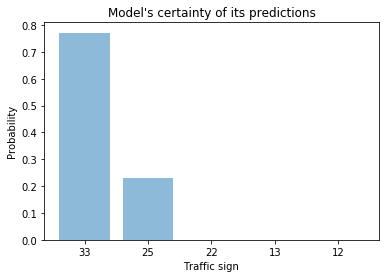

Traffic Sign Key
33 :  Turn right ahead
25 :  Road work
22 :  Bumpy road
13 :  Yield
12 :  Priority road





i1.png


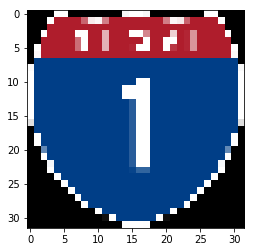

Top five:  TopKV2(values=array([[  1.00000000e+00,   4.19434503e-18,   1.08677887e-29,
          6.71084346e-30,   1.48594288e-30]], dtype=float32), indices=array([[35, 33, 40, 37, 36]]))


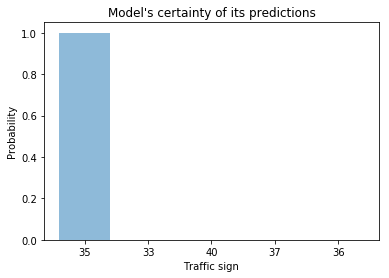

Traffic Sign Key
35 :  Ahead only
33 :  Turn right ahead
40 :  Roundabout mandatory
37 :  Go straight or left
36 :  Go straight or right





i22.png


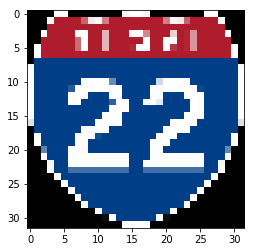

Top five:  TopKV2(values=array([[  1.00000000e+00,   6.12729160e-13,   9.18513549e-15,
          6.62731006e-19,   4.33373360e-25]], dtype=float32), indices=array([[38, 41, 13, 40,  3]]))


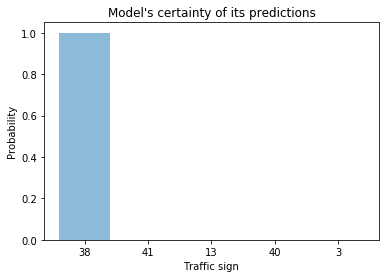

Traffic Sign Key
38 :  Keep right
41 :  End of no passing
13 :  Yield
40 :  Roundabout mandatory
3 :  Speed limit (60km/h)





japanese_sign_resized.png


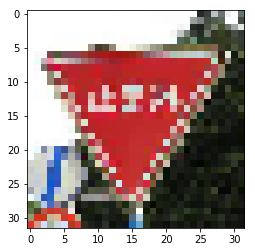

Top five:  TopKV2(values=array([[  1.00000000e+00,   5.30353143e-23,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[17, 14,  0,  1,  2]]))


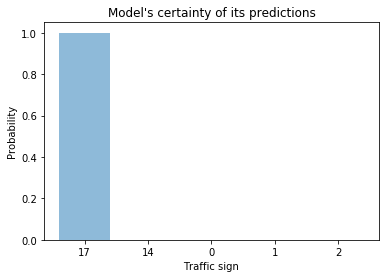

Traffic Sign Key
17 :  No entry
14 :  Stop
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)
2 :  Speed limit (50km/h)





keepleft.png


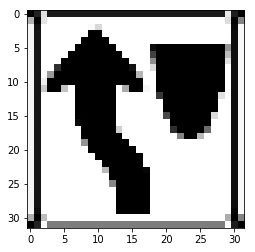

Top five:  TopKV2(values=array([[  9.99683142e-01,   3.16423189e-04,   4.58910677e-07,
          5.36083290e-14,   8.27646354e-20]], dtype=float32), indices=array([[13, 14, 15, 10, 25]]))


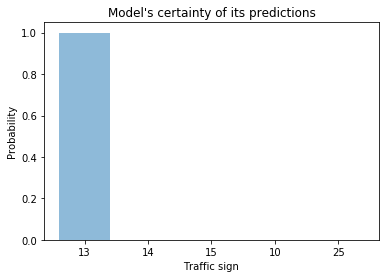

Traffic Sign Key
13 :  Yield
14 :  Stop
15 :  No vehicles
10 :  No passing for vehicles over 3.5 metric tons
25 :  Road work





keepright.png


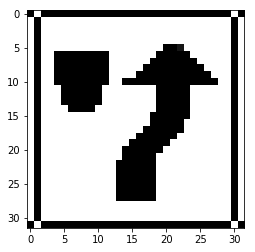

Top five:  TopKV2(values=array([[  1.00000000e+00,   6.64526323e-10,   3.46017215e-10,
          3.10718324e-15,   1.88433491e-16]], dtype=float32), indices=array([[13,  9, 12, 23, 25]]))


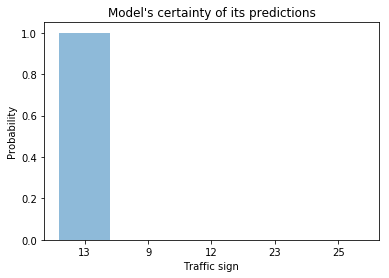

Traffic Sign Key
13 :  Yield
9 :  No passing
12 :  Priority road
23 :  Slippery road
25 :  Road work





noleft.png


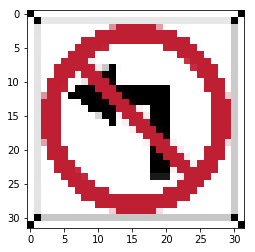

Top five:  TopKV2(values=array([[  9.99995589e-01,   4.41855764e-06,   6.24935936e-11,
          8.73254207e-15,   1.22476697e-15]], dtype=float32), indices=array([[ 2, 33, 17,  9,  4]]))


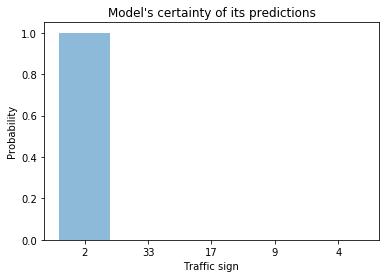

Traffic Sign Key
2 :  Speed limit (50km/h)
33 :  Turn right ahead
17 :  No entry
9 :  No passing
4 :  Speed limit (70km/h)





noleftUturn.png


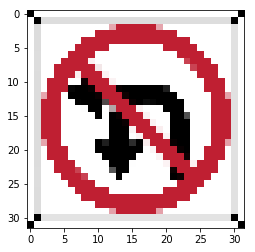

Top five:  TopKV2(values=array([[  9.57131743e-01,   3.91714312e-02,   3.09280888e-03,
          4.61697055e-04,   1.42223202e-04]], dtype=float32), indices=array([[ 2,  9, 17, 16,  0]]))


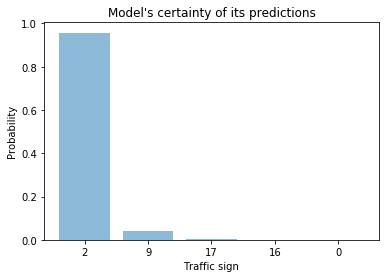

Traffic Sign Key
2 :  Speed limit (50km/h)
9 :  No passing
17 :  No entry
16 :  Vehicles over 3.5 metric tons prohibited
0 :  Speed limit (20km/h)





NoParking.png


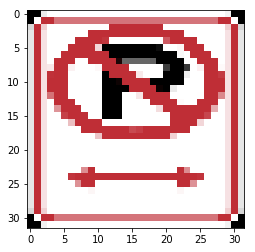

Top five:  TopKV2(values=array([[  9.99999642e-01,   3.51883159e-07,   1.33628820e-11,
          8.08097946e-12,   6.12855469e-12]], dtype=float32), indices=array([[10, 11, 35, 33, 13]]))


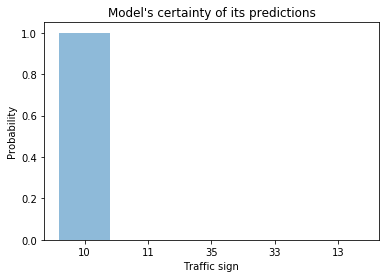

Traffic Sign Key
10 :  No passing for vehicles over 3.5 metric tons
11 :  Right-of-way at the next intersection
35 :  Ahead only
33 :  Turn right ahead
13 :  Yield





noright.png


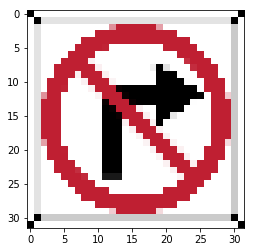

Top five:  TopKV2(values=array([[  9.99990463e-01,   6.16097032e-06,   3.39195935e-06,
          4.63099292e-09,   8.33453098e-11]], dtype=float32), indices=array([[14, 25,  4, 18, 17]]))


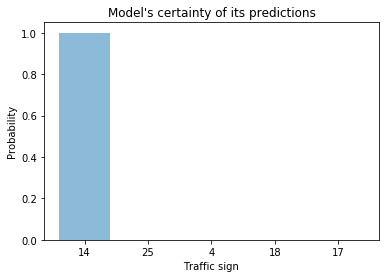

Traffic Sign Key
14 :  Stop
25 :  Road work
4 :  Speed limit (70km/h)
18 :  General caution
17 :  No entry





noRoller.png


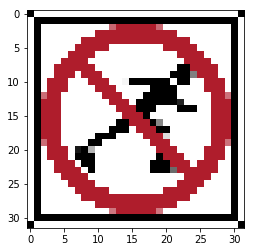

Top five:  TopKV2(values=array([[  1.00000000e+00,   1.76973664e-16,   2.10716522e-20,
          3.50180884e-32,   4.68891931e-34]], dtype=float32), indices=array([[25,  9,  1, 41, 14]]))


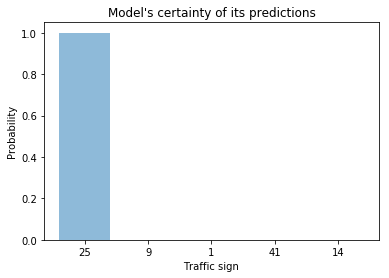

Traffic Sign Key
25 :  Road work
9 :  No passing
1 :  Speed limit (30km/h)
41 :  End of no passing
14 :  Stop





nostraight.png


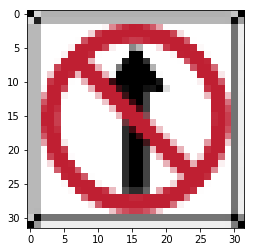

Top five:  TopKV2(values=array([[  4.55018729e-01,   3.59127194e-01,   1.85007110e-01,
          7.56068039e-04,   4.96152534e-05]], dtype=float32), indices=array([[24,  1, 26, 18, 14]]))


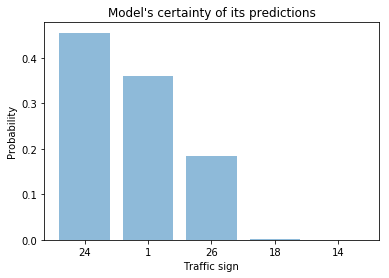

Traffic Sign Key
24 :  Road narrows on the right
1 :  Speed limit (30km/h)
26 :  Traffic signals
18 :  General caution
14 :  Stop





noUturn.png


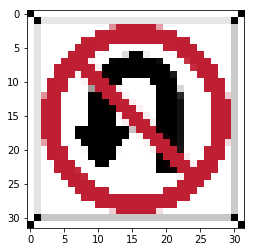

Top five:  TopKV2(values=array([[  9.99811232e-01,   1.67322883e-04,   2.08163110e-05,
          6.42379177e-07,   6.93807500e-09]], dtype=float32), indices=array([[16, 10,  9, 12, 42]]))


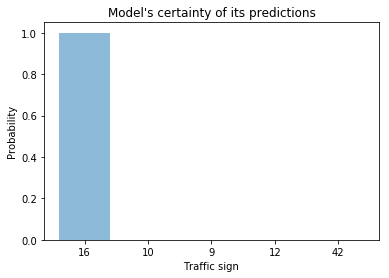

Traffic Sign Key
16 :  Vehicles over 3.5 metric tons prohibited
10 :  No passing for vehicles over 3.5 metric tons
9 :  No passing
12 :  Priority road
42 :  End of no passing by vehicles over 3.5 metric tons





noWalking.png


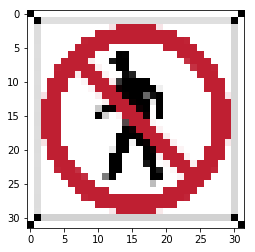

Top five:  TopKV2(values=array([[  9.99984145e-01,   1.53274432e-05,   4.44997141e-07,
          4.76872763e-08,   2.59136844e-11]], dtype=float32), indices=array([[ 1,  3,  2,  5, 21]]))


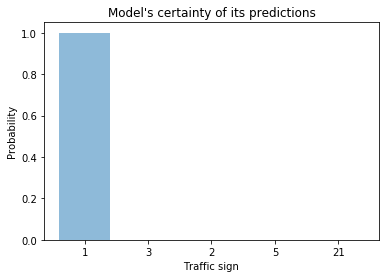

Traffic Sign Key
1 :  Speed limit (30km/h)
3 :  Speed limit (60km/h)
2 :  Speed limit (50km/h)
5 :  Speed limit (80km/h)
21 :  Double curve





paidParking.png


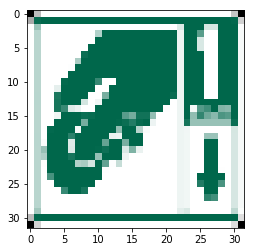

Top five:  TopKV2(values=array([[  9.99614239e-01,   3.81746097e-04,   3.84074065e-06,
          9.72145244e-08,   7.92053445e-09]], dtype=float32), indices=array([[18, 33, 37, 26, 17]]))


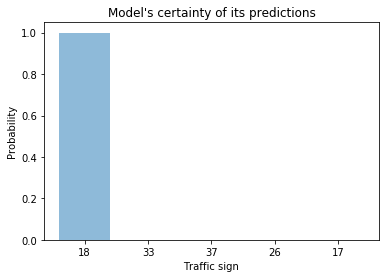

Traffic Sign Key
18 :  General caution
33 :  Turn right ahead
37 :  Go straight or left
26 :  Traffic signals
17 :  No entry





parking2hr.png


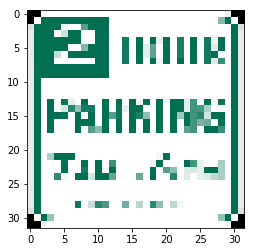

Top five:  TopKV2(values=array([[  9.99770820e-01,   2.25819371e-04,   3.05190792e-06,
          2.56343213e-07,   7.55058245e-16]], dtype=float32), indices=array([[13, 18, 38, 25, 37]]))


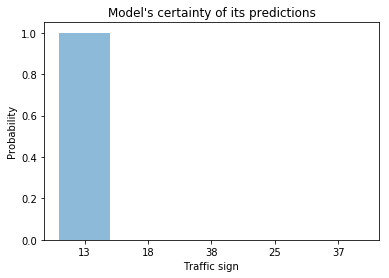

Traffic Sign Key
13 :  Yield
18 :  General caution
38 :  Keep right
25 :  Road work
37 :  Go straight or left





RailRoad.png


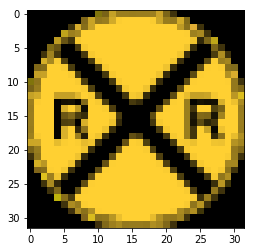

Top five:  TopKV2(values=array([[  9.99515653e-01,   4.32657776e-04,   5.11681137e-05,
          5.79016614e-07,   1.90898430e-09]], dtype=float32), indices=array([[12, 20, 11, 25, 30]]))


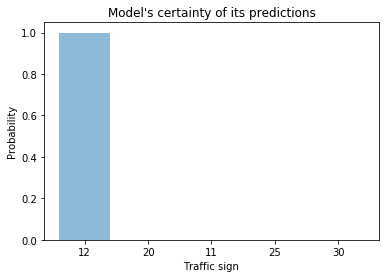

Traffic Sign Key
12 :  Priority road
20 :  Dangerous curve to the right
11 :  Right-of-way at the next intersection
25 :  Road work
30 :  Beware of ice/snow





RightCrossing.png


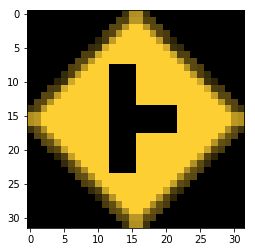

Top five:  TopKV2(values=array([[  1.00000000e+00,   8.59899988e-22,   2.71822030e-22,
          1.24089544e-27,   3.18170511e-30]], dtype=float32), indices=array([[20, 26, 12,  8, 42]]))


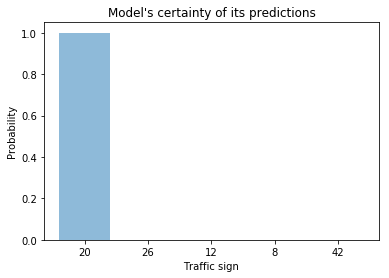

Traffic Sign Key
20 :  Dangerous curve to the right
26 :  Traffic signals
12 :  Priority road
8 :  Speed limit (120km/h)
42 :  End of no passing by vehicles over 3.5 metric tons





roadwork.png


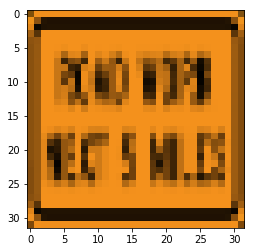

Top five:  TopKV2(values=array([[  9.97832477e-01,   2.16756505e-03,   1.66943620e-23,
          3.95174151e-25,   1.41113320e-27]], dtype=float32), indices=array([[12, 25, 14, 29, 18]]))


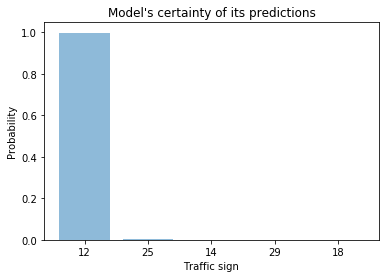

Traffic Sign Key
12 :  Priority road
25 :  Road work
14 :  Stop
29 :  Bicycles crossing
18 :  General caution





shark_sign.png


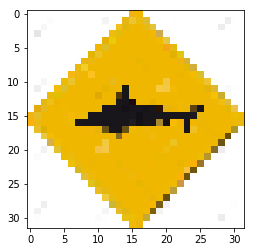

Top five:  TopKV2(values=array([[  1.00000000e+00,   3.56363076e-20,   4.22397344e-31,
          8.22733639e-33,   5.29473108e-33]], dtype=float32), indices=array([[12, 25, 17, 30, 20]]))


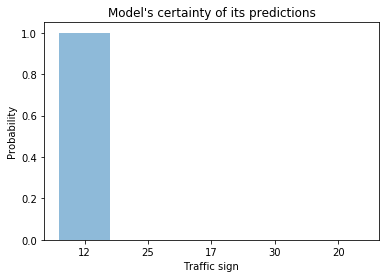

Traffic Sign Key
12 :  Priority road
25 :  Road work
17 :  No entry
30 :  Beware of ice/snow
20 :  Dangerous curve to the right





speed_limit_stop.png


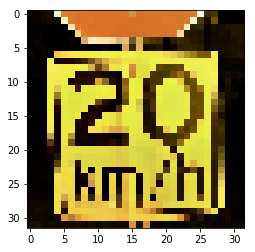

Top five:  TopKV2(values=array([[  1.00000000e+00,   5.79819976e-26,   2.64420888e-34,
          1.73645782e-34,   0.00000000e+00]], dtype=float32), indices=array([[12, 26, 20, 22,  0]]))


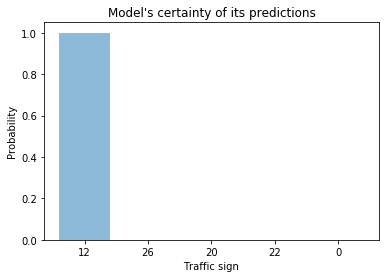

Traffic Sign Key
12 :  Priority road
26 :  Traffic signals
20 :  Dangerous curve to the right
22 :  Bumpy road
0 :  Speed limit (20km/h)





stop.png


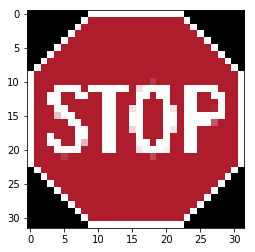

Top five:  TopKV2(values=array([[  8.73517990e-01,   1.26350164e-01,   1.25370047e-04,
          6.48536616e-06,   1.15652359e-08]], dtype=float32), indices=array([[25, 24,  1, 14, 13]]))


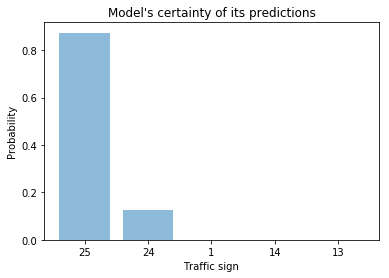

Traffic Sign Key
25 :  Road work
24 :  Road narrows on the right
1 :  Speed limit (30km/h)
14 :  Stop
13 :  Yield





StopAhead.png


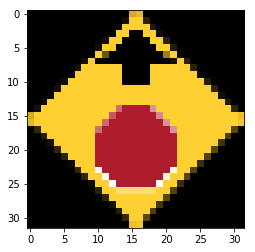

Top five:  TopKV2(values=array([[  1.00000000e+00,   5.42289935e-10,   1.05783150e-30,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[12, 14, 25,  0,  1]]))


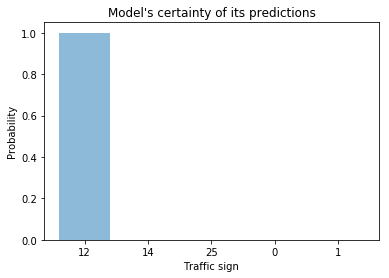

Traffic Sign Key
12 :  Priority road
14 :  Stop
25 :  Road work
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)





TowAway.png


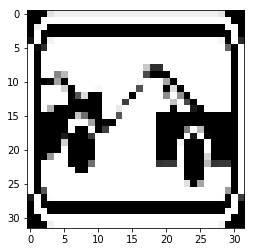

Top five:  TopKV2(values=array([[  1.00000000e+00,   8.72576265e-28,   5.75557000e-37,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[12, 22, 13,  0,  1]]))


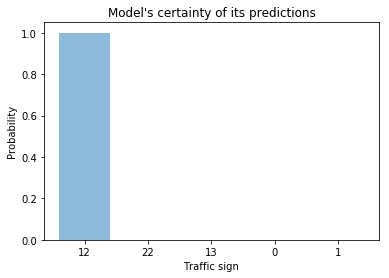

Traffic Sign Key
12 :  Priority road
22 :  Bumpy road
13 :  Yield
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)





two_way_sign.png


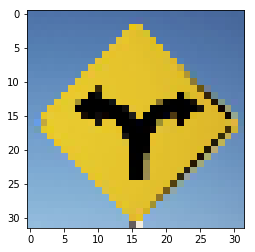

Top five:  TopKV2(values=array([[  1.00000000e+00,   1.29474698e-09,   2.46179077e-10,
          1.58991700e-12,   5.65064525e-22]], dtype=float32), indices=array([[20,  8, 26,  0, 12]]))


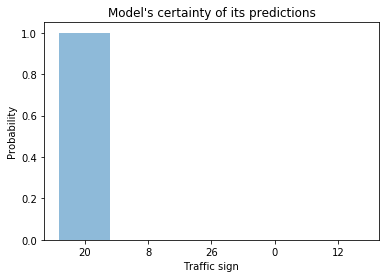

Traffic Sign Key
20 :  Dangerous curve to the right
8 :  Speed limit (120km/h)
26 :  Traffic signals
0 :  Speed limit (20km/h)
12 :  Priority road





US50.png


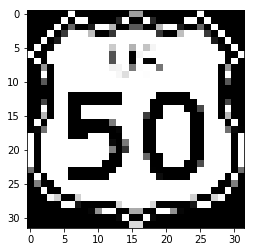

Top five:  TopKV2(values=array([[  1.00000000e+00,   1.77870145e-08,   9.34713529e-10,
          1.83235033e-13,   7.02551962e-14]], dtype=float32), indices=array([[30, 25, 24, 23, 13]]))


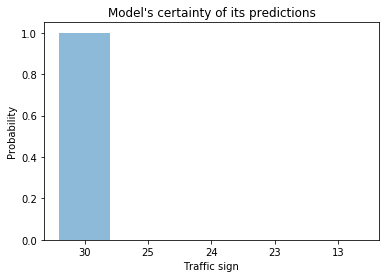

Traffic Sign Key
30 :  Beware of ice/snow
25 :  Road work
24 :  Road narrows on the right
23 :  Slippery road
13 :  Yield





US6.png


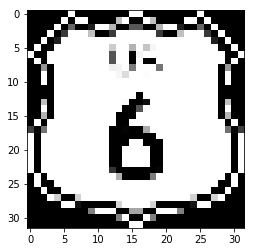

Top five:  TopKV2(values=array([[  1.00000000e+00,   3.07357118e-09,   1.45803882e-19,
          3.46409604e-28,   1.43348339e-30]], dtype=float32), indices=array([[11, 19, 30, 25,  0]]))


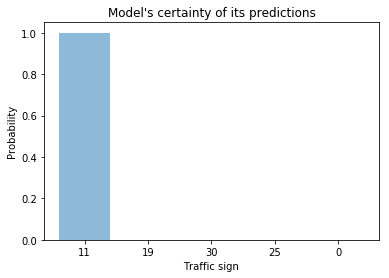

Traffic Sign Key
11 :  Right-of-way at the next intersection
19 :  Dangerous curve to the left
30 :  Beware of ice/snow
25 :  Road work
0 :  Speed limit (20km/h)





windyRight.png


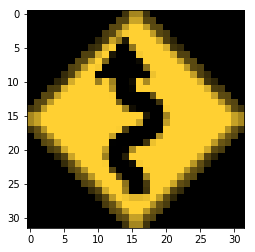

Top five:  TopKV2(values=array([[  9.42513764e-01,   5.74862510e-02,   5.99843388e-17,
          2.31940568e-24,   2.27948836e-30]], dtype=float32), indices=array([[20, 12,  8,  5,  6]]))


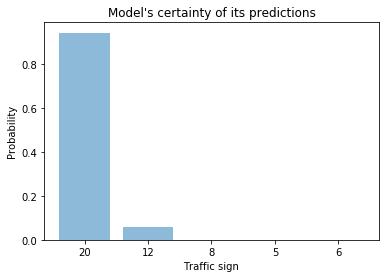

Traffic Sign Key
20 :  Dangerous curve to the right
12 :  Priority road
8 :  Speed limit (120km/h)
5 :  Speed limit (80km/h)
6 :  End of speed limit (80km/h)





workzone.png


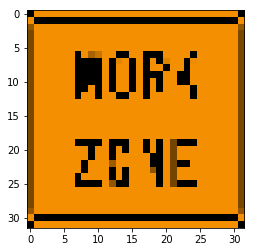

Top five:  TopKV2(values=array([[  1.00000000e+00,   3.10213411e-10,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[12, 25,  0,  1,  2]]))


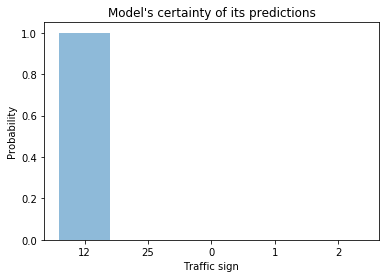

Traffic Sign Key
12 :  Priority road
25 :  Road work
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)
2 :  Speed limit (50km/h)





YCrossing.png


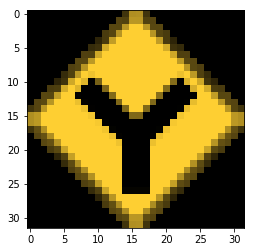

Top five:  TopKV2(values=array([[  1.00000000e+00,   2.00721084e-09,   2.39146881e-27,
          1.22845360e-32,   7.74104907e-34]], dtype=float32), indices=array([[12, 26, 20, 25, 11]]))


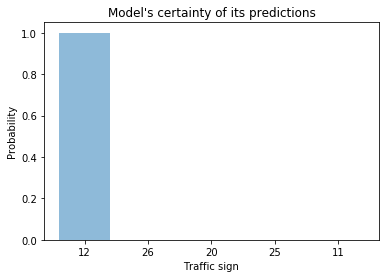

Traffic Sign Key
12 :  Priority road
26 :  Traffic signals
20 :  Dangerous curve to the right
25 :  Road work
11 :  Right-of-way at the next intersection





yeild.png


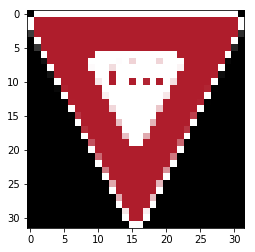

Top five:  TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[13,  0,  1,  2,  3]]))


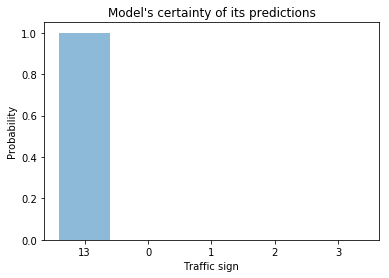

Traffic Sign Key
13 :  Yield
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)
2 :  Speed limit (50km/h)
3 :  Speed limit (60km/h)





yield_pedestrian.png


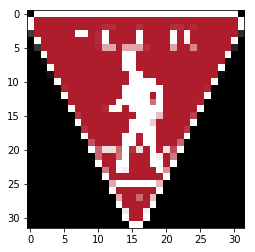

Top five:  TopKV2(values=array([[  1.00000000e+00,   3.72254582e-14,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[12, 13,  0,  1,  2]]))


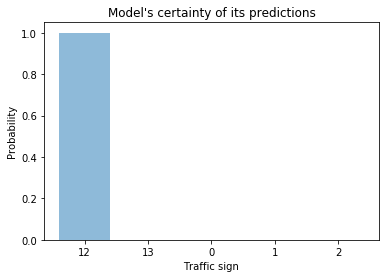

Traffic Sign Key
12 :  Priority road
13 :  Yield
0 :  Speed limit (20km/h)
1 :  Speed limit (30km/h)
2 :  Speed limit (50km/h)


In [23]:
for i in range(len(namenewdata)):
    print('\n\n\n\n')
    print(namenewdata[i])
    plt.imshow(newdata[i]+.5)
    plt.show()
    top_5_predictions(newdata[i]) 

NB: 
1) Special thanks to Jassica young. 
2) Mr. Aurelien Geron who’s book “Hand-On Machine Learning With SciKit-Learn” was a Great help.
